In [101]:
import numpy as np
from pprint import pprint
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [185]:
data = pd.read_pickle('final_data.pkl')

print(data.shape)
data.head(1)

(36814, 828)


,,,Surface,hour,round,p1_win,p1_age,p2_age,k1,k2,p1_height,p2_height,...,p2_filter_lag_1_bp_saved_cnt__mean_28_y,p2_filter_lag_1_bp_saved_cnt__median_28_y,p1_lag_1_match_duration_mnt_mean_28,p1_lag_1_match_duration_mnt_median_28,p1_filter_lag_1_match_duration_mnt_mean_28,p1_filter_lag_1_match_duration_mnt_median_28,p2_lag_1_match_duration_mnt_mean_28,p2_lag_1_match_duration_mnt_median_28,p2_filter_lag_1_match_duration_mnt_mean_28,p2_filter_lag_1_match_duration_mnt_median_28
date,p1,p2,,,,,,,,,,,,,,,,,,,,,
2015-06-01,Gasquet R.,Djokovic N.,0.0,18,1.0,0,28.046575,28.972603,19.0,1.0,1.88,1.83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
y = data['p1_win'].astype(int)
X = data.drop(['p1_win'], axis=1)
date_idx = X.index.get_level_values('date')

In [187]:
## some test periods
test_periods = [
    ('2019-01-01', '2019-04-01'),
    ('2019-04-01', '2019-07-01'),
    ('2019-07-01', '2019-10-01'),
    ('2019-10-01', '2020-04-01'),
    ('2020-08-01', '2020-11-01'),
]

for p in test_periods:
    n_test = data[(date_idx >= p[0]) & (date_idx < p[1])].shape[0]
    print('test period: {}, match count: {:,}'.format(p, n_test))

test period: ('2019-01-01', '2019-04-01'), match count: 2,178
test period: ('2019-04-01', '2019-07-01'), match count: 2,216
test period: ('2019-07-01', '2019-10-01'), match count: 2,170
test period: ('2019-10-01', '2020-04-01'), match count: 2,608
test period: ('2020-08-01', '2020-11-01'), match count: 1,768


In [52]:
test_from, test_to = test_periods[2]

X_test = X[(date_idx >= test_from) & (date_idx < test_to)]
y_test = y[(date_idx >= test_from) & (date_idx < test_to)]
X_train = X[date_idx < test_from]
y_train = y[date_idx < test_from]

In [206]:
def my_accuracy(y_true, y_pred):
    y_pred = np.where(y_pred > 0.5, 1, 0)
    return accuracy_score(y_true, y_pred)

def plot_gs_results(gs_model, params, check_params, model_name = ''):
    plt.figure(figsize=(12,6))
    plt.title(model_name + " dependency from "+ str(check_params))
    plt.plot(params[check_params], gs_model.cv_results_["mean_train_score"],"o-",label="train")
    plt.plot(params[check_params], gs_model.cv_results_["mean_test_score"],"o-",label="test")
    plt.xlabel(check_params)
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()

def gs_regressor_params(parameters ={}, check_parameter={}, metric="accuracy", reg=None, n_splits=1, test_size=0.20):
    metric = make_scorer(my_accuracy)
    cv = TimeSeriesSplit(n_splits=n_splits)
    
    gs_reg = GridSearchCV(reg, parameters, cv=cv,scoring=metric, return_train_score=True, verbose=False)
    gs_reg.fit(X_train,y_train)
    plot_gs_results(gs_model=gs_reg, params=parameters, check_params = check_parameter, model_name=str(reg))

## XGB

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8 
[17:57:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/yasha_ten/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8, score=(train=0.712, test=0.702), total=   0.4s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8 
[17:57:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8, score=(train=0.709, test=0.713), total=   0.8s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8 
[17:57:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s


[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8, score=(train=0.711, test=0.680), total=   1.7s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s


[17:57:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8, score=(train=0.705, test=0.676), total=   2.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.0s remaining:    0.0s


[17:57:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8, score=(train=0.699, test=0.689), total=   3.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.9s remaining:    0.0s


[17:57:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8, score=(train=0.697, test=0.649), total=   4.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   14.8s remaining:    0.0s


[17:57:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8, score=(train=0.689, test=0.671), total=   5.9s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.1s remaining:    0.0s


[17:57:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8, score=(train=0.687, test=0.661), total=   6.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   28.0s remaining:    0.0s


[17:57:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8, score=(train=0.685, test=0.673), total=   7.8s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   36.3s remaining:    0.0s


[17:58:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=1, n_estimators=200, subsample=0.8, score=(train=0.684, test=0.669), total=   8.4s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.8 
[17:58:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.8, score=(train=0.712, test=0.704), total=   0.5s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n

[17:59:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8, score=(train=0.705, test=0.646), total=  15.2s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8 
[18:00:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8, score=(train=0.700, test=0.669), total=  19.2s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=4, n

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.8, score=(train=0.833, test=0.714), total=   4.3s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.8 
[18:05:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.8, score=(train=0.813, test=0.668), total=  10.5s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=8, n_estimators=200, subsample=0.8 
[18:05:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8, score=(train=0.856, test=0.658), total= 1.1min
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8 
[18:15:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8, score=(train=0.856, test=0.661), total= 1.3min
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.8 
[18:16:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 20.4min finished


[18:17:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


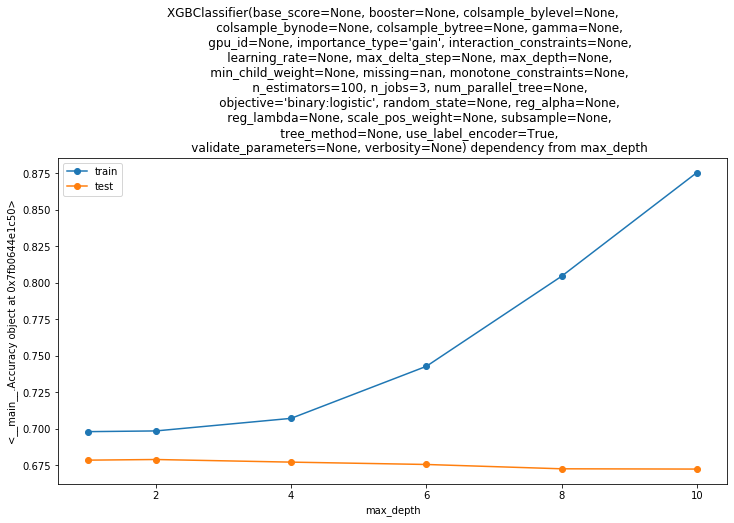

In [155]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [1, 2, 4, 6, 8, 10],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'n_estimators': [200]
}
gs_regressor_params(parameters=grid_params,check_parameter='max_depth',reg= xgb.XGBClassifier(n_jobs=3), n_splits=10)

Fitting 10 folds for each of 34 candidates, totalling 340 fits
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8 
[18:49:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8, score=(train=0.712, test=0.700), total=   0.1s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[18:49:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8, score=(train=0.707, test=0.714), total=   0.2s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[18:49:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8, score=(train=0.711, test=0.680), total=   0.3s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[18:49:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8, score=(train=0.703, test=0.673), total=   0.4s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


[18:49:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8, score=(train=0.697, test=0.690), total=   0.5s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s


[18:49:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8, score=(train=0.696, test=0.649), total=   0.5s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.2s remaining:    0.0s


[18:49:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8, score=(train=0.689, test=0.671), total=   0.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.2s remaining:    0.0s


[18:49:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8, score=(train=0.687, test=0.662), total=   0.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.2s remaining:    0.0s


[18:49:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8, score=(train=0.684, test=0.674), total=   0.7s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.4s remaining:    0.0s


[18:49:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=2, subsample=0.8, score=(train=0.683, test=0.671), total=   0.7s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=17, subsample=0.8 
[18:49:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=17, subsample=0.8, score=(train=0.712, test=0.700), total=   0.1s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_est

[18:50:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=32, subsample=0.8, score=(train=0.696, test=0.649), total=   1.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=32, subsample=0.8 
[18:50:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=32, subsample=0.8, score=(train=0.690, test=0.671), total=   1.9s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_es

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=62, subsample=0.8, score=(train=0.710, test=0.714), total=   0.5s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=62, subsample=0.8 
[18:50:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=62, subsample=0.8, score=(train=0.712, test=0.679), total=   0.9s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=62, subsample=0.8 
[18:50:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=77, subsample=0.8, score=(train=0.688, test=0.663), total=   6.3s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=77, subsample=0.8 
[18:52:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=77, subsample=0.8, score=(train=0.685, test=0.673), total=   7.4s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=77, subsample=0.8 
[18:52:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=107, subsample=0.8, score=(train=0.705, test=0.673), total=   3.0s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=107, subsample=0.8 
[18:53:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=107, subsample=0.8, score=(train=0.699, test=0.692), total=   4.1s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=107, subsample=0.8 
[18:53:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=122, subsample=0.8, score=(train=0.684, test=0.668), total=   9.0s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=137, subsample=0.8 
[18:55:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=137, subsample=0.8, score=(train=0.712, test=0.701), total=   0.4s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=137, subsample=0.8 
[18:55:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=152, subsample=0.8, score=(train=0.697, test=0.653), total=   6.0s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=152, subsample=0.8 
[18:56:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=152, subsample=0.8, score=(train=0.690, test=0.671), total=   7.3s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=152, subsample=0.8 
[18:56:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=182, subsample=0.8, score=(train=0.711, test=0.720), total=   1.0s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=182, subsample=0.8 
[18:57:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=182, subsample=0.8, score=(train=0.711, test=0.680), total=   2.3s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=182, subsample=0.8 
[18:57:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=197, subsample=0.8, score=(train=0.688, test=0.663), total=  10.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=197, subsample=0.8 
[18:59:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=197, subsample=0.8, score=(train=0.685, test=0.673), total=  12.1s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=197, subsample=0.8 
[18:59:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=227, subsample=0.8, score=(train=0.705, test=0.675), total=   4.7s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=227, subsample=0.8 
[19:01:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=227, subsample=0.8, score=(train=0.699, test=0.691), total=   6.4s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=227, subsample=0.8 
[19:01:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=242, subsample=0.8, score=(train=0.685, test=0.668), total=  22.5s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=257, subsample=0.8 
[19:04:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=257, subsample=0.8, score=(train=0.712, test=0.701), total=   0.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=257, subsample=0.8 
[19:04:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=272, subsample=0.8, score=(train=0.698, test=0.651), total=  11.0s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=272, subsample=0.8 
[19:07:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=272, subsample=0.8, score=(train=0.691, test=0.671), total=  13.5s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=272, subsample=0.8 
[19:07:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=302, subsample=0.8, score=(train=0.714, test=0.721), total=   1.7s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=302, subsample=0.8 
[19:10:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=302, subsample=0.8, score=(train=0.712, test=0.679), total=   3.8s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=302, subsample=0.8 
[19:10:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=317, subsample=0.8, score=(train=0.688, test=0.664), total=  17.2s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=317, subsample=0.8 
[19:13:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=317, subsample=0.8, score=(train=0.685, test=0.673), total=  19.1s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=317, subsample=0.8 
[19:13:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=347, subsample=0.8, score=(train=0.706, test=0.676), total=   7.0s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=347, subsample=0.8 
[19:16:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=347, subsample=0.8, score=(train=0.700, test=0.689), total=  10.2s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=347, subsample=0.8 
[19:16:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=362, subsample=0.8, score=(train=0.685, test=0.669), total=  27.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=377, subsample=0.8 
[19:20:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=377, subsample=0.8, score=(train=0.713, test=0.700), total=   0.8s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=377, subsample=0.8 
[19:20:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=392, subsample=0.8, score=(train=0.699, test=0.651), total=  14.0s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=392, subsample=0.8 
[19:24:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=392, subsample=0.8, score=(train=0.692, test=0.670), total=  18.1s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=392, subsample=0.8 
[19:24:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=422, subsample=0.8, score=(train=0.716, test=0.715), total=   2.2s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=422, subsample=0.8 
[19:27:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=422, subsample=0.8, score=(train=0.714, test=0.677), total=   5.2s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=422, subsample=0.8 
[19:28:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=437, subsample=0.8, score=(train=0.689, test=0.663), total=  23.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=437, subsample=0.8 
[19:41:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=437, subsample=0.8, score=(train=0.687, test=0.673), total=  26.2s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=437, subsample=0.8 
[19:41:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=467, subsample=0.8, score=(train=0.708, test=0.671), total=   9.1s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=467, subsample=0.8 
[19:45:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=467, subsample=0.8, score=(train=0.701, test=0.691), total=  13.0s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=467, subsample=0.8 
[19:45:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=482, subsample=0.8, score=(train=0.686, test=0.670), total=  34.0s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=497, subsample=0.8 
[19:50:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=497, subsample=0.8, score=(train=0.715, test=0.700), total=   1.1s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=497, subsample=0.8 
[19:50:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[Parallel(n_jobs=1)]: Done 340 out of 340 | elapsed: 63.4min finished


[19:53:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


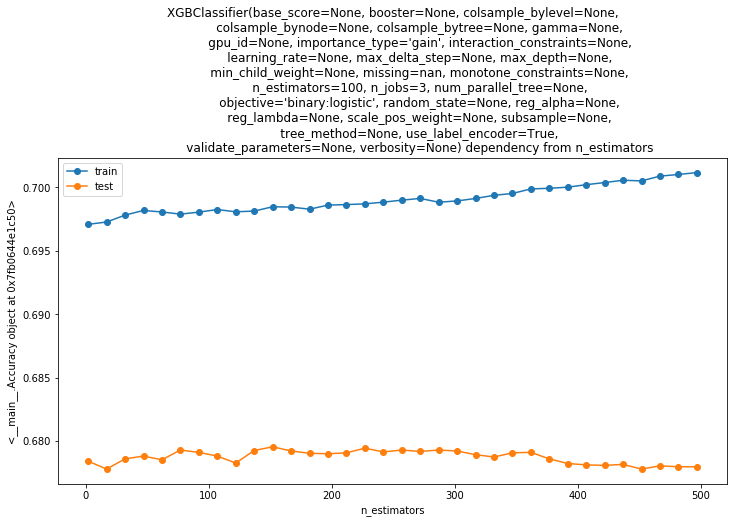

In [164]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'n_estimators': range(2, 500, 15)
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='n_estimators',reg=xgb.XGBClassifier(n_jobs=3), n_splits=10)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2 
[01:04:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2, score=(train=0.714, test=0.699), total=   0.5s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2 
[01:04:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2, score=(train=0.710, test=0.721), total=   0.9s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2 
[01:04:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2, score=(train=0.714, test=0.681), total=   1.7s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s


[01:04:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2, score=(train=0.705, test=0.673), total=   2.7s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.3s remaining:    0.0s


[01:04:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2, score=(train=0.699, test=0.689), total=   3.8s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.4s remaining:    0.0s


[01:05:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2, score=(train=0.697, test=0.650), total=   4.8s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.5s remaining:    0.0s


[01:05:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2, score=(train=0.691, test=0.670), total=   5.9s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   21.7s remaining:    0.0s


[01:05:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2, score=(train=0.688, test=0.662), total=   7.0s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   29.1s remaining:    0.0s


[01:05:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2, score=(train=0.685, test=0.671), total=   8.2s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   37.7s remaining:    0.0s


[01:05:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.2, score=(train=0.683, test=0.666), total=   9.2s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.4 
[01:05:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.4, score=(train=0.712, test=0.702), total=   0.5s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n

[01:06:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.6, score=(train=0.697, test=0.650), total=   7.8s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.6 
[01:07:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=0.6, score=(train=0.690, test=0.670), total=   9.7s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n

[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.710, test=0.714), total=   1.3s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 
[01:09:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.713, test=0.681), total=   2.9s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 
[01:09:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.8min finished


[01:10:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


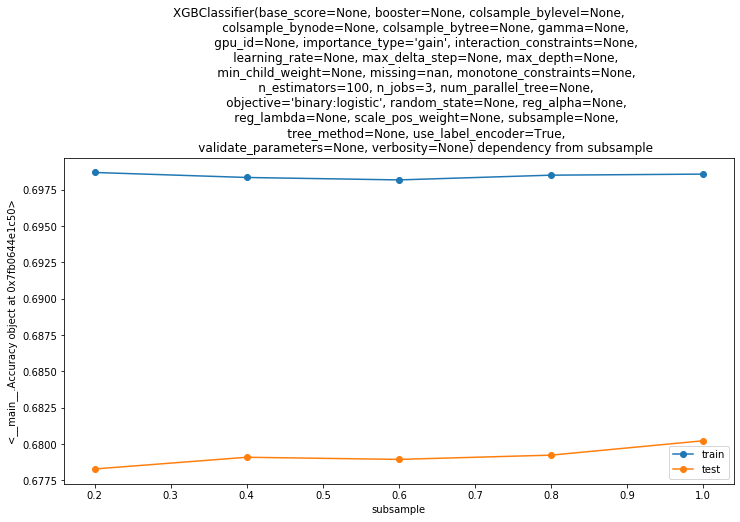

In [180]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
    'colsample_bytree': [0.8],
    'n_estimators': [220]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='subsample',reg=xgb.XGBClassifier(n_jobs=3), n_splits=10)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 
[01:20:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/yasha_ten/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.713, test=0.701), total=   0.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 
[01:20:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.710, test=0.714), total=   1.5s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[01:20:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.713, test=0.681), total=   3.4s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s


[01:20:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.704, test=0.674), total=   6.1s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.1s remaining:    0.0s


[01:20:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.699, test=0.691), total=   7.9s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.2s remaining:    0.0s


[01:20:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.697, test=0.652), total=  10.7s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   31.2s remaining:    0.0s


[01:20:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.691, test=0.674), total=  14.0s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   45.7s remaining:    0.0s


[01:21:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.688, test=0.667), total=  14.6s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s


[01:21:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.686, test=0.674), total=  17.4s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min remaining:    0.0s


[01:21:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.685, test=0.676), total=  16.6s
[CV] colsample_bytree=0.8, learning_rate=0.02, max_depth=2, n_estimators=220, subsample=1.0 
[01:21:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.02, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.712, test=0.700), total=   0.5s
[CV] colsample_bytree=0.8, learning_rate=0.02, max_depth=2, n

[01:23:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.04, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.702, test=0.651), total=   8.8s
[CV] colsample_bytree=0.8, learning_rate=0.04, max_depth=2, n_estimators=220, subsample=1.0 
[01:23:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.04, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.697, test=0.664), total=  10.8s
[CV] colsample_bytree=0.8, learning_rate=0.04, max_depth=2, n

[CV]  colsample_bytree=0.8, learning_rate=0.16, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.753, test=0.679), total=   1.6s
[CV] colsample_bytree=0.8, learning_rate=0.16, max_depth=2, n_estimators=220, subsample=1.0 
[01:26:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.16, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.746, test=0.665), total=   3.4s
[CV] colsample_bytree=0.8, learning_rate=0.16, max_depth=2, n_estimators=220, subsample=1.0 
[01:26:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[CV]  colsample_bytree=0.8, learning_rate=0.3, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.729, test=0.639), total=  12.8s
[CV] colsample_bytree=0.8, learning_rate=0.3, max_depth=2, n_estimators=220, subsample=1.0 
[01:29:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.3, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.724, test=0.653), total=  14.6s
[CV] colsample_bytree=0.8, learning_rate=0.3, max_depth=2, n_estimators=220, subsample=1.0 
[01:29:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed: 10.9min finished


[01:31:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


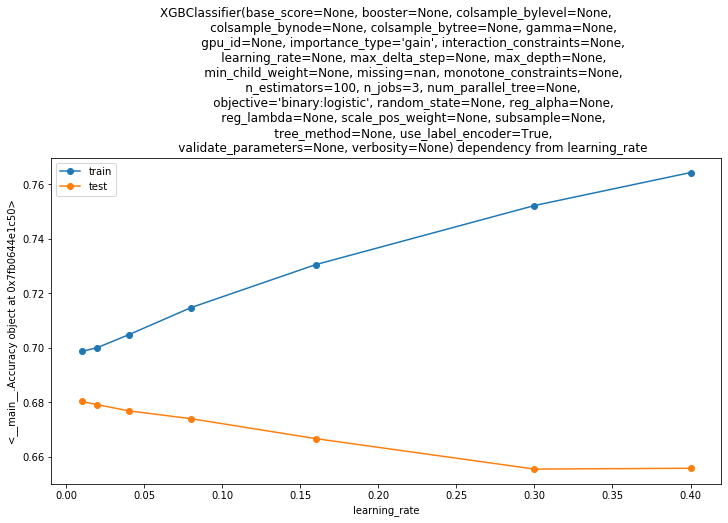

In [181]:
grid_params = {
    'learning_rate': [0.01, 0.02, 0.04, 0.08, 0.16, 0.3, 0.4], 
    'max_depth': [2],
    'subsample': [1.0],
    'colsample_bytree': [0.8],
    'n_estimators': [220]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='learning_rate',reg=xgb.XGBClassifier(n_jobs=3), n_splits=10)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 
[02:00:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.713, test=0.702), total=   0.6s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 
[02:00:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.712, test=0.711), total=   1.1s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 
[02:00:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.715, test=0.681), total=   2.1s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.1s remaining:    0.0s


[02:00:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.706, test=0.667), total=   3.4s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.7s remaining:    0.0s


[02:00:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.699, test=0.689), total=   4.7s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.7s remaining:    0.0s


[02:00:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.697, test=0.650), total=   6.0s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.0s remaining:    0.0s


[02:01:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.692, test=0.674), total=   7.4s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   26.7s remaining:    0.0s


[02:01:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.689, test=0.662), total=   8.8s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   36.0s remaining:    0.0s


[02:01:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.687, test=0.672), total=  10.3s
[CV] colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   46.8s remaining:    0.0s


[02:01:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.4, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.685, test=0.676), total=  11.3s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 
[02:01:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.713, test=0.701), total=   0.7s
[CV] colsample_bytree=0.8, learning_rate=0.01, max_depth=2, n

[02:03:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.85, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.697, test=0.651), total=  10.9s
[CV] colsample_bytree=0.85, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 
[02:03:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=0.85, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.691, test=0.674), total=  13.7s
[CV] colsample_bytree=0.85, learning_rate=0.01, max_depth=

[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.708, test=0.713), total=   1.8s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 
[02:07:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  colsample_bytree=1.0, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0, score=(train=0.711, test=0.680), total=   4.1s
[CV] colsample_bytree=1.0, learning_rate=0.01, max_depth=2, n_estimators=220, subsample=1.0 
[02:07:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd li

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.2min finished


[02:08:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


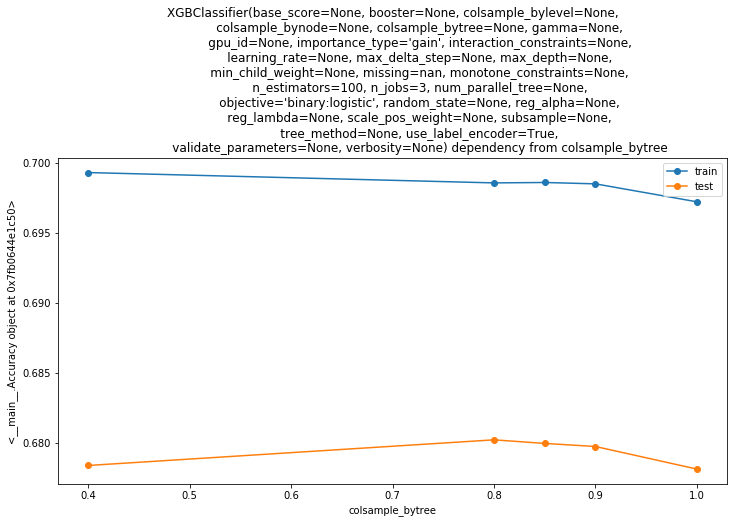

In [184]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [2],
    'subsample': [1.0],
    'colsample_bytree': [0.4, 0.8, 0.85, 0.9, 1.0],
    'n_estimators': [220]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='colsample_bytree',reg=xgb.XGBClassifier(n_jobs=3), n_splits=10)

## CatBoost

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.712, test=0.701), total=   0.4s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.706, test=0.721), total=   0.9s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.711, test=0.680), total=   5.6s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.703, test=0.673), total=  11.2s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.2s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.697, test=0.689), total=   2.6s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.8s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.696, test=0.649), total=   1.6s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   22.5s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.689, test=0.671), total=   1.9s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.4s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.687, test=0.662), total=   1.9s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   26.3s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.684, test=0.673), total=   2.0s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   28.3s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.683, test=0.671), total=  13.6s
[CV] learning_rate=0.01, max_depth=3, n_estimators=220, subsample=1.0 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=220, subsample=1.0, score=(train=0.713, test=0.699), total=   4.5s
[CV] learning_rate=0.01, max_depth=3, n_estimators=220, subsample=1.0 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=220, subsample=1.0, score=(train=0.709, test=0.723), total=   2.0s
[CV] learning_rate=0.01, max_depth=3, n_estimators=220, subsample=1.0 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=220, subsample=1.0, score=(train=0.712, test=0.679), total=   3.1s
[CV] learning_rate=0.01, max_depth=3, n_estimators=220, subsample=1.0 
[CV]  learning_rate=0.01, max_depth=3, n_estimators=220, subsample=1.0, score=(train=0.704, test=0.674), total=   2.9s
[CV] learning_rate=0.01, max_depth=3, n_estimators=220, subsample=1.0 
[CV]  learning_rate=0.01, max_depth=3, n_estimator

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 15.9min finished


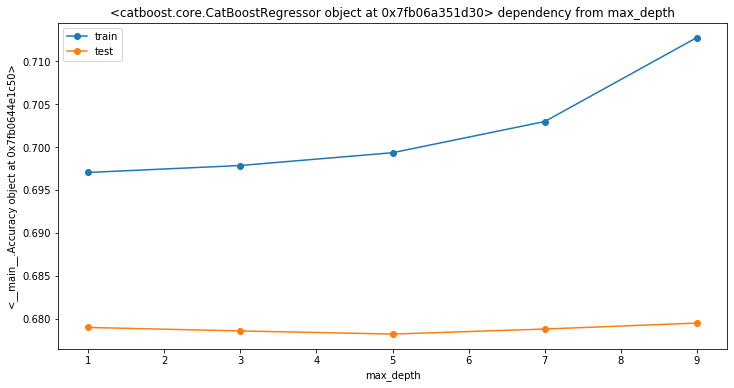

In [197]:
import catboost
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': range(1, 10, 2),
    'subsample': [1.0],
    'n_estimators': [220]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='max_depth',reg= catboost.CatBoostRegressor(verbose=False), n_splits=10)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.712, test=0.701), total=   0.3s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.706, test=0.721), total=   0.5s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.711, test=0.680), total=   0.7s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.6s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.703, test=0.673), total=   0.9s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.5s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.697, test=0.689), total=   1.0s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.696, test=0.649), total=   0.9s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.5s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.689, test=0.671), total=   1.3s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.9s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.687, test=0.662), total=   1.2s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    7.1s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.684, test=0.673), total=   1.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    8.2s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.683, test=0.671), total=   1.5s
[CV] learning_rate=0.02, max_depth=1, n_estimators=220, subsample=1.0 
[CV]  learning_rate=0.02, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.711, test=0.701), total=   0.2s
[CV] learning_rate=0.02, max_depth=1, n_estimators=220, subsample=1.0 
[CV]  learning_rate=0.02, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.704, test=0.721), total=   0.6s
[CV] learning_rate=0.02, max_depth=1, n_estimators=220, subsample=1.0 
[CV]  learning_rate=0.02, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.711, test=0.680), total=   0.8s
[CV] learning_rate=0.02, max_depth=1, n_estimators=220, subsample=1.0 
[CV]  learning_rate=0.02, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.703, test=0.673), total=   1.0s
[CV] learning_rate=0.02, max_depth=1, n_estimators=220, subsample=1.0 
[CV]  learning_rate=0.02, max_depth=1, n_estimator

[CV]  learning_rate=0.3, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.708, test=0.668), total=   0.7s
[CV] learning_rate=0.3, max_depth=1, n_estimators=220, subsample=1.0 .
[CV]  learning_rate=0.3, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.701, test=0.689), total=   0.8s
[CV] learning_rate=0.3, max_depth=1, n_estimators=220, subsample=1.0 .
[CV]  learning_rate=0.3, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.698, test=0.646), total=   1.0s
[CV] learning_rate=0.3, max_depth=1, n_estimators=220, subsample=1.0 .
[CV]  learning_rate=0.3, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.692, test=0.670), total=   1.0s
[CV] learning_rate=0.3, max_depth=1, n_estimators=220, subsample=1.0 .
[CV]  learning_rate=0.3, max_depth=1, n_estimators=220, subsample=1.0, score=(train=0.689, test=0.661), total=   1.0s
[CV] learning_rate=0.3, max_depth=1, n_estimators=220, subsample=1.0 .
[CV]  learning_rate=0.3, max_depth=1, n_estimators=220,

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.1min finished


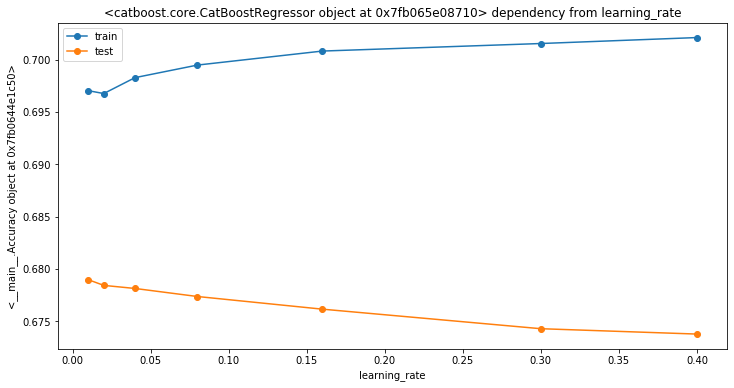

In [204]:
grid_params = {
    'learning_rate': [0.01, 0.02, 0.04, 0.08, 0.16, 0.3, 0.4],
    'max_depth': [1],
    'subsample': [1.0],
    'n_estimators': [220]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='learning_rate',reg= catboost.CatBoostRegressor(verbose=False), n_splits=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0 .
[CV]  learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0, score=(train=0.707, test=0.702), total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0 .
[CV]  learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0, score=(train=0.706, test=0.721), total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0, score=(train=0.711, test=0.680), total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0 .
[CV]  learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0, score=(train=0.703, test=0.673), total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0 .


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0, score=(train=0.697, test=0.689), total=   0.2s
[CV] learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0 .
[CV]  learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0, score=(train=0.696, test=0.649), total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0 .


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0, score=(train=0.689, test=0.671), total=   0.3s
[CV] learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0 .


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.1s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0, score=(train=0.687, test=0.662), total=   0.2s
[CV] learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0 .


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.3s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0, score=(train=0.684, test=0.673), total=   0.2s
[CV] learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0 .


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.6s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=10, subsample=1.0, score=(train=0.683, test=0.666), total=   0.3s
[CV] learning_rate=0.01, max_depth=1, n_estimators=60, subsample=1.0 .
[CV]  learning_rate=0.01, max_depth=1, n_estimators=60, subsample=1.0, score=(train=0.712, test=0.701), total=   0.2s
[CV] learning_rate=0.01, max_depth=1, n_estimators=60, subsample=1.0 .
[CV]  learning_rate=0.01, max_depth=1, n_estimators=60, subsample=1.0, score=(train=0.706, test=0.721), total=   0.2s
[CV] learning_rate=0.01, max_depth=1, n_estimators=60, subsample=1.0 .
[CV]  learning_rate=0.01, max_depth=1, n_estimators=60, subsample=1.0, score=(train=0.711, test=0.680), total=   0.2s
[CV] learning_rate=0.01, max_depth=1, n_estimators=60, subsample=1.0 .
[CV]  learning_rate=0.01, max_depth=1, n_estimators=60, subsample=1.0, score=(train=0.703, test=0.673), total=   0.5s
[CV] learning_rate=0.01, max_depth=1, n_estimators=60, subsample=1.0 .
[CV]  learning_rate=0.01, max_depth=1, n_estimators=60,

[CV]  learning_rate=0.01, max_depth=1, n_estimators=260, subsample=1.0, score=(train=0.703, test=0.673), total=   0.8s
[CV] learning_rate=0.01, max_depth=1, n_estimators=260, subsample=1.0 
[CV]  learning_rate=0.01, max_depth=1, n_estimators=260, subsample=1.0, score=(train=0.697, test=0.689), total=   0.9s
[CV] learning_rate=0.01, max_depth=1, n_estimators=260, subsample=1.0 
[CV]  learning_rate=0.01, max_depth=1, n_estimators=260, subsample=1.0, score=(train=0.696, test=0.649), total=   1.0s
[CV] learning_rate=0.01, max_depth=1, n_estimators=260, subsample=1.0 
[CV]  learning_rate=0.01, max_depth=1, n_estimators=260, subsample=1.0, score=(train=0.689, test=0.671), total=   1.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=260, subsample=1.0 
[CV]  learning_rate=0.01, max_depth=1, n_estimators=260, subsample=1.0, score=(train=0.687, test=0.662), total=   1.2s
[CV] learning_rate=0.01, max_depth=1, n_estimators=260, subsample=1.0 
[CV]  learning_rate=0.01, max_depth=1, n_estimator

[CV]  learning_rate=0.01, max_depth=1, n_estimators=460, subsample=1.0, score=(train=0.687, test=0.662), total=   1.9s
[CV] learning_rate=0.01, max_depth=1, n_estimators=460, subsample=1.0 
[CV]  learning_rate=0.01, max_depth=1, n_estimators=460, subsample=1.0, score=(train=0.684, test=0.673), total=   2.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=460, subsample=1.0 
[CV]  learning_rate=0.01, max_depth=1, n_estimators=460, subsample=1.0, score=(train=0.683, test=0.671), total=   2.2s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished


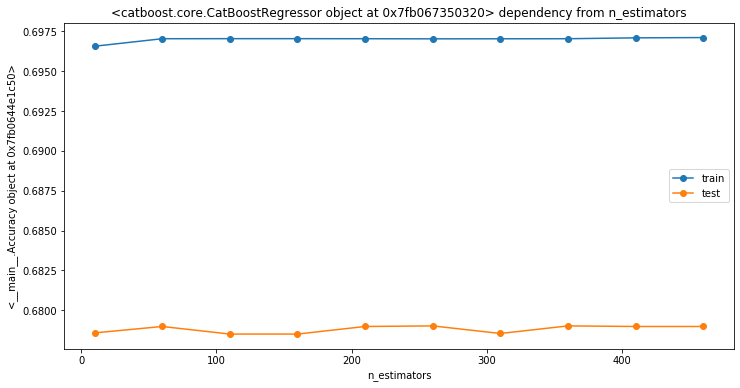

In [202]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [1],
    'subsample': [1.0],
    'n_estimators': range(10, 500, 50)
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='n_estimators',reg= catboost.CatBoostRegressor(verbose=False), n_splits=10)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6, score=(train=0.712, test=0.701), total=   0.3s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6, score=(train=0.706, test=0.721), total=   0.5s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6, score=(train=0.711, test=0.679), total=   0.7s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6, score=(train=0.703, test=0.674), total=   0.7s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.2s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6, score=(train=0.697, test=0.689), total=   0.8s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6, score=(train=0.696, test=0.649), total=   0.8s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.8s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6, score=(train=0.689, test=0.671), total=   1.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    5.0s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6, score=(train=0.687, test=0.662), total=   1.0s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    6.0s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6, score=(train=0.684, test=0.673), total=   1.0s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    7.0s remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.6, score=(train=0.683, test=0.666), total=   1.2s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.8, score=(train=0.712, test=0.701), total=   0.2s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.8, score=(train=0.706, test=0.721), total=   0.5s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.8, score=(train=0.711, test=0.680), total=   0.6s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.8, score=(train=0.703, test=0.673), total=   0.7s
[CV] learning_rate=0.01, max_depth=1, n_estimators=220, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=1, n_estimator

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   29.1s finished


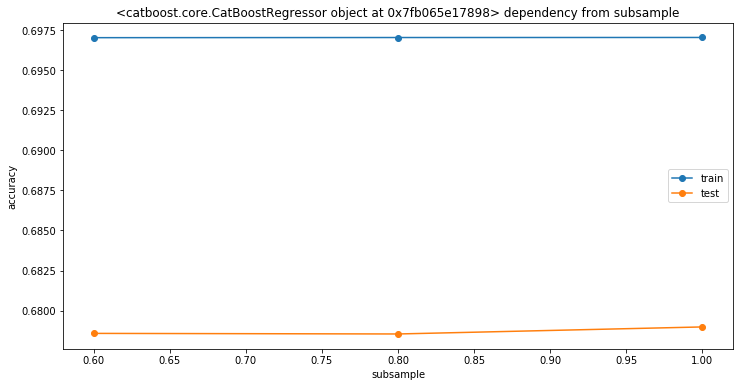

In [208]:
grid_params = {
    'learning_rate': [0.01], 
    'max_depth': [1],
    'subsample': [0.6, 0.8, 1.0],
    'n_estimators': [220]
}
gs_regressor_params(parameters=grid_params,
                    check_parameter='subsample',reg= catboost.CatBoostRegressor(verbose=False), n_splits=10)

In [ ]:
cv = TimeSeriesSplit(n_splits=10)

grid_params = {
    'learning_rate': [0.01, 0.02, 0.04], 
    'max_depth': [1, 2, 4, 6],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8],
    'n_estimators': [220, 500]
}
model_init = xgb.XGBClassifier(tree_method='hist', booster='gbtree', random_state=13)
gsearch = GridSearchCV(model_init, param_grid=grid_params, cv=cv)
gsearch.fit(X_train, y_train)

/Users/yasha_ten/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:46:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:46:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:46:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:46:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[20:47:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:47:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:47:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:47:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[20:48:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:48:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:48:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:48:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[20:51:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:51:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:51:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:51:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[20:55:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [ ]:
pprint(gsearch.cv_results_)
pprint(gsearch.best_params_)
pprint(gsearch.best_score_)
gsearch.score